In [1]:
import sys
sys.path.append('/home/corvus/code/greenpeace/AQMesh/')  # needed for query.py

In [23]:
# general
import datetime as dt

# data handling
import numpy as np
import pandas as pd
%matplotlib inline

# plotting
import plotly.plotly as py
import plotly.graph_objs as go

# from imports
from plotly.tools import FigureFactory as FF
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot  # for offline use
from pandas.io import gbq

from query import Query  # custom

# run plotly offline and initialize notebook plotting
init_notebook_mode(connected=True)

In [100]:
# getting timestamps and values for NO for Id 827150
UniqueId = 827150

# fixed time interval because of data scarcity
begin = dt.datetime(year=2017, month=10, day=12, tzinfo=dt.timezone.utc)
end = dt.datetime(year=2018, month=2, day=13, tzinfo=dt.timezone.utc)

q = Query(SELECT="TBTimestamp AS ts, NO_Scaled AS nos",
          FROM="`exeter-science-unit.airmonitor.airmonitor`",
          WHERE=f"UniqueID = {UniqueId} AND NO_Status = 'Valid' AND NO_Scaled >= 0" 
                f" AND TBTimestamp >= '{begin}' AND TBTimestamp <= '{end}'",
          ORDERBY="ts")

NO_df = gbq.read_gbq(str(q), dialect='standard')

NO_df.ts = pd.to_datetime(NO_df.ts)
NO_df.index = NO_df.ts 
#NO_df = NO_df.resample('D').mean()
NO_df = NO_df.resample('6H').mean()

In [105]:
# for CO
q = Query(SELECT="TBTimestamp AS ts, CO_Scaled AS co",
          FROM="`exeter-science-unit.airmonitor.airmonitor`",
          WHERE=f"UniqueID = {UniqueId} AND CO_Status = 'Valid' AND CO_Scaled >= 0" 
                f" AND TBTimestamp >= '{begin}' AND TBTimestamp <= '{end}'",
          ORDERBY="ts")

CO_df = gbq.read_gbq(str(q), dialect='standard')

CO_df.ts = pd.to_datetime(CO_df.ts)  # converting timestamp to datetime
CO_df.index = CO_df.ts  # setting index to ts
CO_df = CO_df.resample('6H').mean()  # resampling to 6h averages

## Plotting with Pandas 

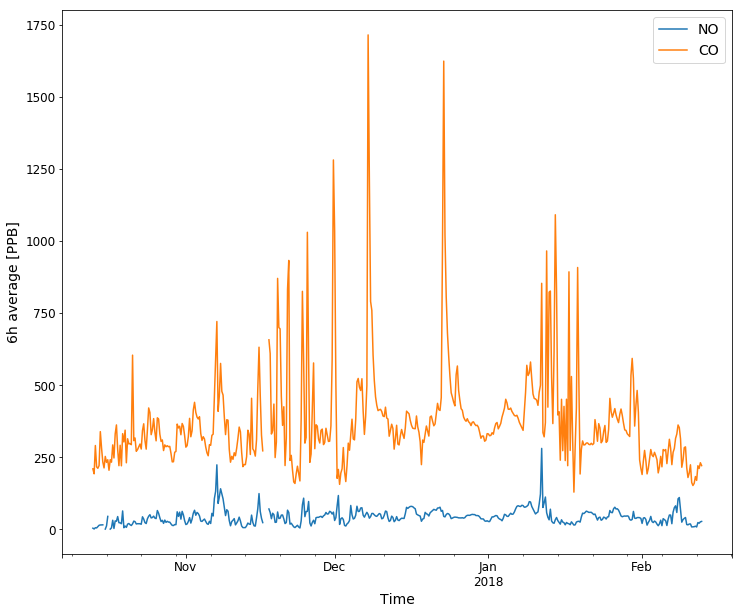

In [109]:
# plotting with pandas
ax = NO_df.plot(style='-', ms=5, figsize=(12, 10), fontsize=12)
CO_df.plot(style='-', ms=5, fontsize=12, ax=ax)
ax.set_ylabel('6h average [PPB]', fontsize=14)
ax.set_xlabel('Time', fontsize=14)
ax.legend(['NO', 'CO'], fontsize=14)

## Plotting with Plotly

In [112]:
# plotting with plotly
no = go.Scatter(x=NO_df.index, y=NO_df.nos, name='NO')
co = go.Scatter(x=CO_df.index, y=CO_df.co, name='CO')
data = [no, co]
layout = go.Layout(showlegend=True)
fig = go.Figure(data=data, layout=layout)
fig.layout.yaxis.update({'title': '6h average [PPB]'})
fig.layout.xaxis.update({'title': 'Time [days]'})
iplot(fig)

In [101]:
NO_df.resample?

RangeIndex(start=0, stop=171286, step=1)